In [252]:
import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
import cv2
import torch

import kornia as K
import kornia.feature as KF
from kornia.feature.adalam import AdalamFilter
from kornia_moons.viz import *

In [221]:
device = K.utils.get_cuda_or_mps_device_if_available()
print(device)

cuda:0


In [235]:
def sentinel_chanel_path(n, chanel, r_filter = False, path = 'SentinelData'):
    """
    Returns the path to the specified channel of a selected Sentinel image from the directory.

    Args:
    n (int): Index of the image from the directory (path).
    chanel (str): Code of the channel. There are 14 channels available in the data: 
                  B01, B02, ..., B08, B08A, B09, B10, B11, B12, TCI (RGB channel).
    r_filter (str, optional): A filter string for the image placement. Default is False.
    path (str, optional): Path to the directory containing Sentinel images. Default is 'SentinelData'.
   """
    
    # Get the list of directories inside the 'path'.
    listdir = os.listdir(path)
    
    # Apply filter if 'r_filter' is specified
    if r_filter:
        listdir = [dir for dir in listdir if r_filter in dir]
        if not listdir:
            raise ValueError(f"Folder {path} does not contains images from selected placement {r_filter}")
            
    # Construct the path to the selected image directory
    path = os.path.join(path, listdir[n])
    path = os.path.join(path, os.listdir(path)[0])
    path = os.path.join(path, 'GRANULE')
    path = os.path.join(path, os.listdir(path)[0])
    path = os.path.join(path, 'IMG_DATA')
    
    # Find the file matching the specified channel name
    filename = [filename for filename in os.listdir(path) if chanel in filename][0]
    if not filename:
        raise ValueError(f"Not corect chanel name {chanel}.")
        
    # Get the full path to the channel file
    path = os.path.join(path, filename)
    
    return path

In [234]:
def load_sentinel_img(path, divider = 1):
    """
    Loads an image from the Sentinel data, splitting it into quarters to reduce memory load, 
    and resizes each quarter.

    Args:
    path (str): path to the file
    divider (float, optional): Factor by which to reduce the resolution of the image.

    Returns:
    numpy.ndarray: A resized and recombined image.
    """
    # Open the Sentinel image using rasterio
    with rasterio.open(path) as file:
        # Get the width and height of the image
        width = file.width
        height = file.height
        
        # Calculate the dimensions of each quarter (split into 4 parts)
        quadrant_width = width // 4
        quadrant_height = height // 4

        resized_quadrants = []  # List to store the resized quarters
        
        # Loop through each quarter (4 quarters total)
        for i in range(4):
            row = i // 2  # Determine row (top or bottom)
            col = i % 2  # Determine column (left or right)

            # Calculate the offset for each quarter
            x_off = col * quadrant_width
            y_off = row * quadrant_height

            # Define the window to read a specific quarter from the image
            window = rasterio.windows.Window(x_off, y_off, quadrant_width, quadrant_height)
            img = file.read(window=window)  # Read the quadrant data
            
            # Transpose the image from (channels, height, width) to (height, width, channels)
            img = np.transpose(img, (1, 2, 0))
            
            # Resize the image quarter
            img_resized = resize(img, (img.shape[0] // divider, img.shape[1] // divider), anti_aliasing=True)
            resized_quadrants.append(img_resized)  # Add the resized quadrant to the list

        # Combine the resized quarters into two rows: top and bottom
        top_row = np.concatenate((resized_quadrants[0], resized_quadrants[1]), axis=1)
        bottom_row = np.concatenate((resized_quadrants[2], resized_quadrants[3]), axis=1)
        
        # Combine the two rows into the final image
        full_image = np.concatenate((top_row, bottom_row), axis=0)

        return full_image

In [255]:
#load first image
rgb_band_path = sentinel_chanel_path(0, "TCI", 'R064')
print(rgb_band_path)
img1_arr = load_sentinel_img(rgb_band_path, 8)

SentinelData/S2A_MSIL1C_20160212T084052_N0201_R064_T36UYA_20160212T084510/S2A_MSIL1C_20160212T084052_N0201_R064_T36UYA_20160212T084510.SAFE/GRANULE/L1C_T36UYA_A003350_20160212T084510/IMG_DATA/T36UYA_20160212T084052_TCI.jp2


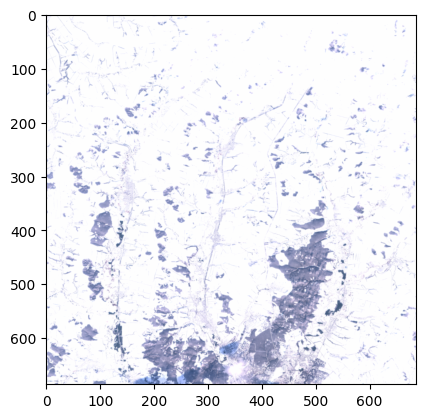

In [256]:
plt.imshow(img1_arr)

In [244]:
#load second image
rgb_band_path = sentinel_chanel_path(3, "TCI", 'R064')
print(rgb_band_path)
img2_arr = load_sentinel_img(rgb_band_path, 8)

SentinelData/S2A_MSIL1C_20160830T083602_N0204_R064_T36UYA_20160830T083600/S2A_MSIL1C_20160830T083602_N0204_R064_T36UYA_20160830T083600.SAFE/GRANULE/L1C_T36UYA_A006210_20160830T083600/IMG_DATA/T36UYA_20160830T083602_TCI.jp2


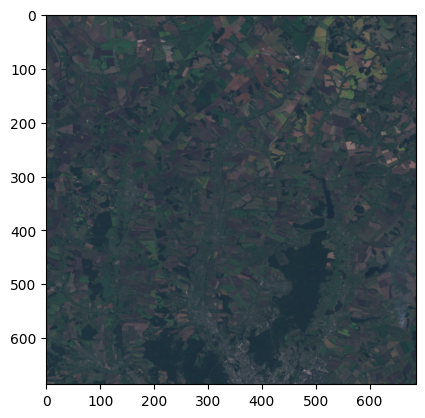

In [245]:
plt.imshow(img2_arr)

In [257]:
#convert numpy arrays (W, H, C) to torch tensors (B, C, W, H)
img1 = torch.from_numpy(img1_arr).float().to(device).permute(2, 0, 1).unsqueeze(0)
img2 = torch.from_numpy(img2_arr).float().to(device).permute(2, 0, 1).unsqueeze(0)

In [258]:
# Initialize the Light Glue Matcher object with the disk model
lg_matcher = KF.LightGlueMatcher("disk").eval().to(device)

# Define the number of keypoints to detect
num_features = 512

# Load the pre-trained DISK model for "epipolar" geometry. "depth" gives a worse perfomance.
disk = KF.DISK.from_pretrained("epipolar").to(device)

# Get the height and width of the images
hw1 = torch.tensor(img1.shape[2:], device=device)
hw2 = torch.tensor(img2.shape[2:], device=device)

# Perform inference without computing gradients
with torch.inference_mode():
    # Concatenate the two images (img1 and img2) along the batch dimension
    inp = torch.cat([img1, img2], dim=0)
    
    # Extract features from both images using the DISK model
    features1, features2 = disk(inp, num_features, pad_if_not_divisible=True)
    
    # Extract keypoints and descriptors for both images
    kps1, descs1 = features1.keypoints, features1.descriptors
    kps2, descs2 = features2.keypoints, features2.descriptors
    
    # Compute the Local Affine Frames (LAFs) for both images from the keypoints
    lafs1 = KF.laf_from_center_scale_ori(kps1[None], torch.ones(1, len(kps1), 1, 1, device=device))
    lafs2 = KF.laf_from_center_scale_ori(kps2[None], torch.ones(1, len(kps2), 1, 1, device=device))
    
    # Match the descriptors between the two images using Light Glue Matcher
    dists, idxs = lg_matcher(descs1, descs2, lafs1, lafs2, hw1=hw1, hw2=hw2)

# Print the number of tentative matches between the two images
print(f"{idxs.shape[0]} tentative matches with DISK LightGlue")

Loaded LightGlue model
63 tentative matches with DISK LightGlue


In [259]:
def get_matching_keypoints(kp1, kp2, idxs):
    """
    Retrieves the matching keypoints from two sets of keypoints based on the indices.

    Args:
    kp1 (torch.Tensor): Keypoints from the first image.
    kp2 (torch.Tensor): Keypoints from the second image.
    idxs (torch.Tensor): Indices of matching keypoints between the two images.

    Returns:
    torch.Tensor, torch.Tensor: Matching keypoints from both images.
    """
    # Use the indices to select the corresponding keypoints from both sets
    mkpts1 = kp1[idxs[:, 0]]  # Matching keypoints from the first image
    mkpts2 = kp2[idxs[:, 1]]  # Matching keypoints from the second image
    return mkpts1, mkpts2

# Get the matching keypoints using the indices obtained from LightGlue matcher
mkpts1, mkpts2 = get_matching_keypoints(kps1, kps2, idxs)

# Convert the keypoints to numpy arrays for OpenCV processing
# Detach from the computation graph, move to CPU, and convert to numpy
mkpts1_np = mkpts1.detach().cpu().numpy()
mkpts2_np = mkpts2.detach().cpu().numpy()

# Use OpenCV to compute the Fundamental Matrix (Fm) and inliers from the matching keypoints
Fm, inliers = cv2.findFundamentalMat(
    mkpts1_np, mkpts2_np, cv2.USAC_MAGSAC, 1.0, 0.999, 100000
)

# Convert the inliers to boolean values (True for inliers, False for outliers)
inliers = inliers > 0

# Print the number of inliers found
print(f"{inliers.sum()} inliers with DISK")

44 inliers with DISK


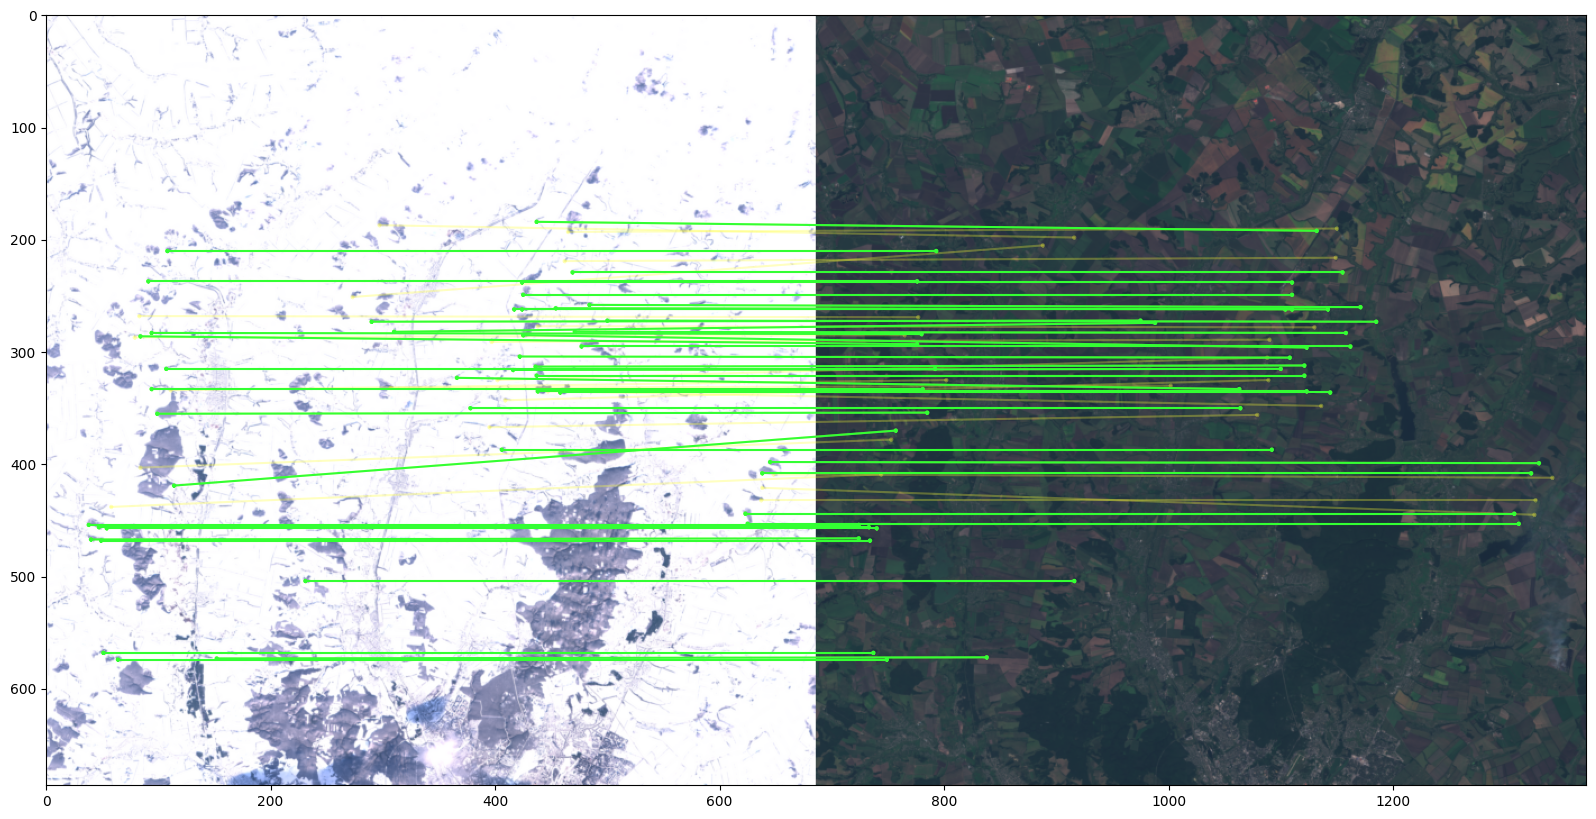

In [260]:
# Draw the matches between two sets of keypoints using Local Affine Frames (LAFs)
draw_LAF_matches(
    # Convert the keypoints to Local Affine Frames (LAFs) for both images
    KF.laf_from_center_scale_ori(kps1[None].cpu()),
    KF.laf_from_center_scale_ori(kps2[None].cpu()),

    # Provide the indices of the matches between the keypoints from both images
    idxs.cpu(),

    # Convert from tensors to numpy arrays
    K.tensor_to_image(img1.cpu()),
    K.tensor_to_image(img2.cpu()),

    # Provide the inliers that are geometrically consistent matches
    inliers,

    # Drawing options dictionary specifying the colors for different match categories
    draw_dict={
        "inlier_color": (0.2, 1, 0.2),  # Color for inlier matches (greenish)
        "tentative_color": (1, 1, 0.2, 0.3),  # Color for tentative matches (yellow with transparency)
        "feature_color": None,  # No color specified for feature points
        "vertical": False  # Whether to stack the images vertically or not (False means side-by-side)
    },
)